In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: BUDZYNSKI, PAWEL (1511734)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

Presented model performs quite well if considering it's level of complexity and time to train. The network has pyramid shape, so no information is lost during the learning process. I tried to add larger layer as at the beginnig of network but it resulted in increasing overfitting. Input layer has 3072 nodes because it's the size of "flattened" picture, last layer - softmax, returns probabilty of belonging to given class. SGD optimizer gave the best result for this setting (length: 477)



Max val score: 84.24%


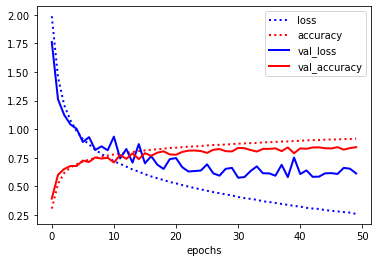

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 768)               2360064   
_________________________________________________________________
dense_27 (Dense)             (None, 512)               393728    
_________________________________________________________________
dense_28 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 10)                650       
Total params: 2,828,362
Trainable params: 2,828,362
Non-trainable params: 0
____________________________________________

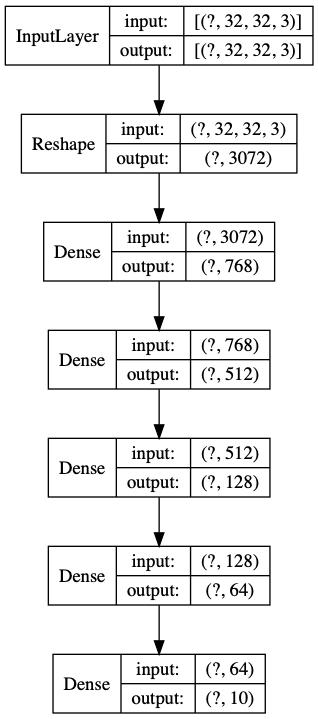

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

Comparing to 1_1 now we use gray-scale picture, so in practice picture has one channel instead of 3. Imput size was significantly reduced - 3 times, while information presented on the picures should be similar. The choice of 1st hidden layer stays relevant for this case becuse it's smaller than input size. Model performance doesn't improve significantly but it has much less parameters. Learning curves are a bit smoother. (length: 425)



Max val score: 84.74%


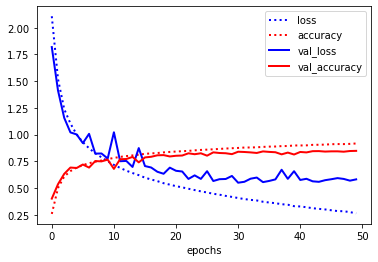

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 768)               787200    
_________________________________________________________________
dense_32 (Dense)             (None, 512)               393728    
_________________________________________________________________
dense_33 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                650       
Total params: 1,255,498
Trainable params: 1,255,498
Non-trainable params: 0
____________________________________________

def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(768, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Model was simplified, I reduced amount of nodes, added dropout and batch normalization, thus the model is better generalizing. Learning curves are very smooth and there's no evidence for overfitting. Scores for training and validation sets are very similar so model generalzie well. Batch_size is a compromise between accuracy and the peace of learning, bigger one made learning faster but decreased acuracy. Experiments with leaning rate didn't give any significant improvement of final accuracy. (length: 498)



Max val score: 87.21%


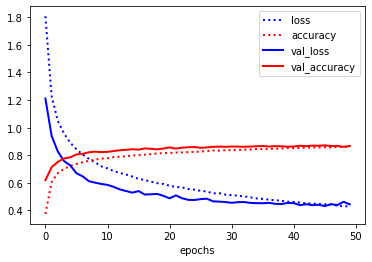

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(600, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(400, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.SGD(lr=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Model is a result of experimentation. Padding "same" applied to all conv layers to not to loose data. Tets with larger filters 5x5 lead only to overfitting without improvement on validation set. Batch normalisations and dropout was applied because network has tendence to strongly overfit. ReLU activation prevents vanishing gradient. Regularisations were slowing down training process and didn't lead to accuracy improvements so eventually are not present. Adam optimizer is beforming very well in this case (compared with SGD), batch size was increased to speed up learning process. Finall performance is well, accuracy is much better than dense network 1_3, learning curves are smooth and no overfitting present. (length: 716)



Max val score: 94.52%


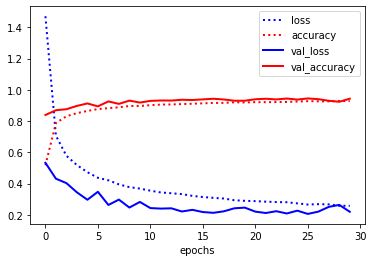

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_51 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_52 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 64)      

def build_model_2_1():
  model = models.Sequential()
  #ConvNet
  model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.3))
  #DenseNet
  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(30, activation='relu'))
  model.add(layers.Dropout(0

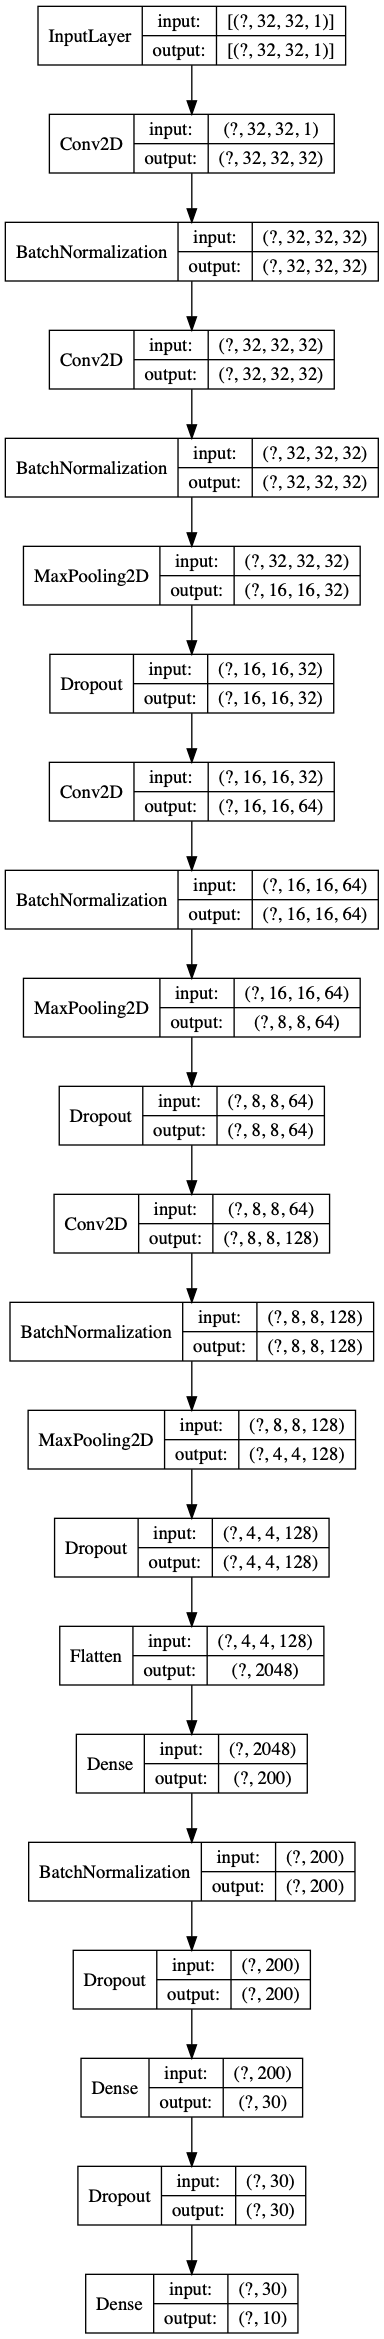

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

No significant improvement can be noticed. No rotation used because usually address numbers are hanging straight. Small width and height shifts were applied because a lot of numbers are already on the edge of the pictures. Eventually small improvement of the performance was noticed while trainig accuracy slightly decreased, it might prove a better generalisation but training takes much longer. (length: 397)



Max val score: 95.22%


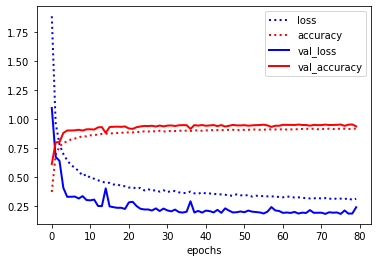


augmentation = ImageDataGenerator(rotation_range=0,
                                  zoom_range=0,
                                  width_shift_range=0.05,
                                  height_shift_range=0.05)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Confusion matrix shows that the most misclassification is present for simillar numbers (1vs7, 5vs3). It's also visible that the dataset is not very well balanced and 1 is present much more often than other numbers, network is probable to missclassify numbers and predict 1 which is visible in 1st column of confusion matrix. (length: 325)

Test score: [0.23335699314004477, 0.9368013]


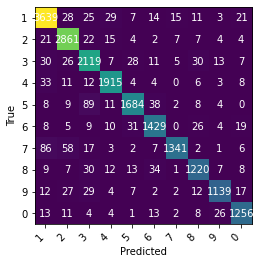

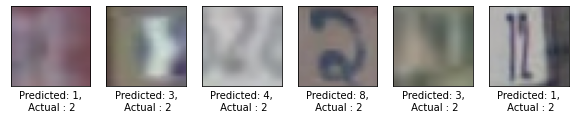

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

It is visible how network is able to recognize high-level features in the first layers, we can clearly recognize shape of the number there. Some of the filters were not activated so we can suspect that they correspond to other shapes/locations. In deeper layers netowork focus on more low level features and it's hard to interpret these visualisations. (length: 353)



Model prediction: 8


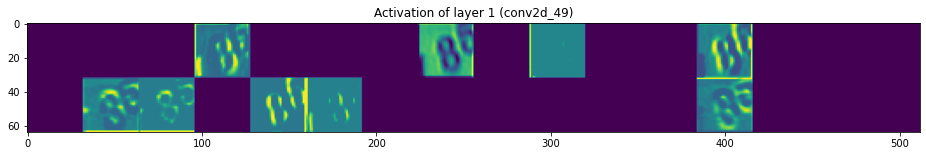

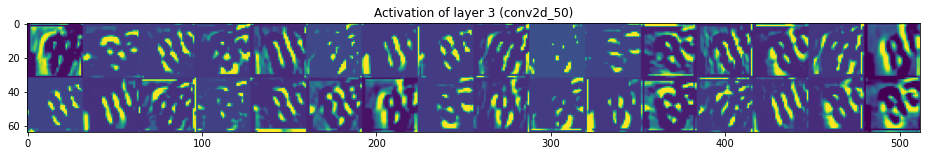

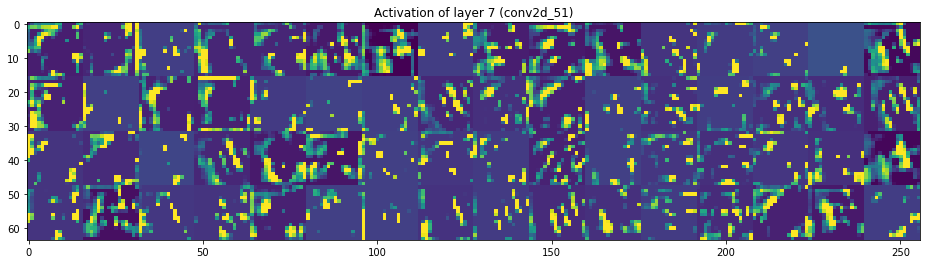

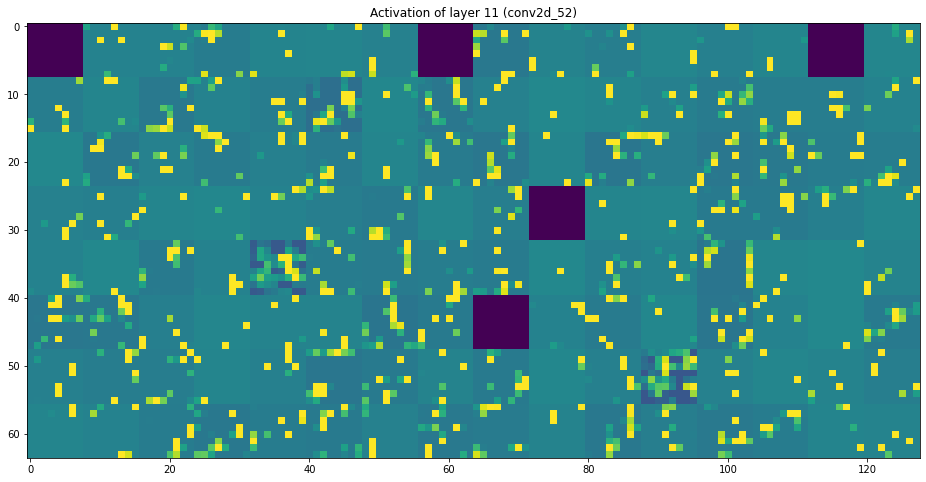

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

ERROR, could not build class activation plot. Please check original report
def plot_3_3():
  # ----- IMPORTANT: This code worked normally but crashed while running verfy.py so image was saved
  
  # tf.compat.v1.disable_eager_execution()
  # model = load_model_from_file(base_dir, "model_2_2")
  # img_tensor_bw = bw_X_test[0]
  # img_tensor_bw = np.expand_dims(img_tensor_bw, axis=0)

  # eight_output = model.output[:, 7]
  # last_conv_layer = model.get_layer("conv2d_52")
  
  # grads = K.gradients(eight_output, last_conv_layer.output)[0]
  # pooled_grads = K.mean(grads, axis=(0, 1, 2))
  # iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  # pooled_grads_value, conv_layer_output_value = iterate([img_tensor_bw])

  # for i in range(128):
  #   conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # heatmap = np.mean(conv_layer_output_value, axis=-1)

  # heatmap = np.maximum(heatmap, 0)
  # heatmap /= np.max(heatmap)

  # img = X_test[0]
  # heatmap =

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

The usage of raw vgg16 did not give satisfying classification ressults. All experiments with different dense parts gave poor accuracy perforance. Allowing last 3 convolutional layers to learn slightly improved the situation. Although, learning process does not go so well, network seems to be overfitting as validation loss does not decrease. (length: 343)



Max val score: 83.00%


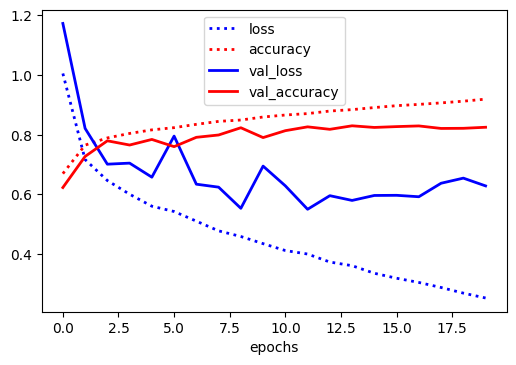

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 1, 512)         2048      
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               51300     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)               

def build_model_4_1():
  vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3), pooling=None, classes=10)
  trainable_vgg16_layers = ['block5_conv3', 'block5_conv2', 'block5_conv1']
  for layer in vgg16.layers:
    if layer.name in trainable_vgg16_layers:
      layer.trainable = True
    else:
      layer.trainable = False

  model = models.Sequential()
  model.add(vgg16)
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.4))
  # model.add(layers.Dense(30, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  return model



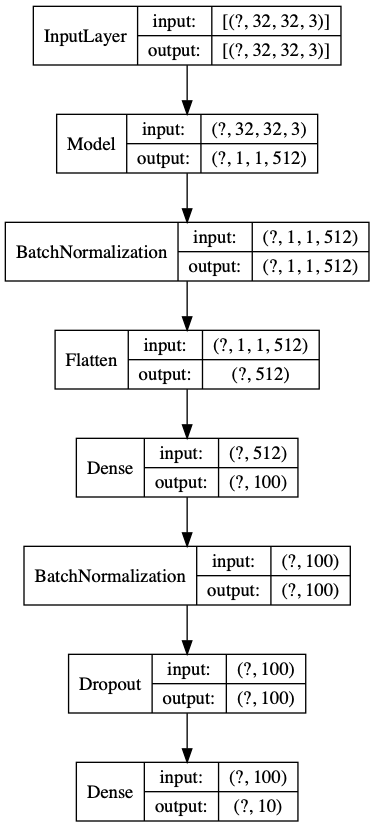

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

The process can be understand as features extraction, when we change meaningful from human point of view data into set of features. I tried to find suitable model for this classification task. The results of some models(SVM, RFs) slightly outperform model 4_1, but are worse than one achieved in model 2_2. Seems like output of vgg16 is not really the best set of fetures for this classification task. However we sill can try to take advantage of transfer learning and unfroze more layers of vgg16. (length: 499)

Pipeline(steps=[('transform',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('pca', PCA()),
                ('clf', RandomForestClassifier(n_estimators=20, n_jobs=-1))])
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  model = load_model_from_file(base_dir, "model_4_1", extension='.h5')
  vgg16 = model.get_layer('vgg16')
  model_output = models.Sequential()
  model_output.add(vgg16)
  model_output.add(layers.Flatt

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 11.24 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
